<a href="https://colab.research.google.com/github/IzumiSatoshi/deforumed-walk/blob/main/deforum_walk_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers accelerate transformers
!pip install numpngw timm einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.4 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/IzumiSatoshi/deforumed-walk.git

Cloning into 'deforumed-walk'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 72 (delta 23), reused 52 (delta 13), pack-reused 0
Unpacking objects: 100% (72/72), 4.22 MiB | 8.25 MiB/s, done.


In [3]:
%cd deforumed-walk/

/content/deforumed-walk


In [4]:
import sys
sys.path.append("/content/deforumed-walk/src")
from warp import AnimArgs
from depth import DepthModel
import torch
import math
import py3d_tools as p3d
from einops import rearrange
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers.schedulers import DPMSolverMultistepScheduler, DDIMScheduler, EulerAncestralDiscreteScheduler
from IPython import display
import time
from diffusers import DiffusionPipeline 
import torch 

In [5]:
def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    return new_image

In [6]:

pipe = DiffusionPipeline.from_pretrained(
    "/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1",
    custom_pipeline="lpw_stable_diffusion",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [7]:
depth_model = DepthModel(torch.device("cuda"), "/content/drive/MyDrive/AI/models/dpt_large-midas-2f21e586.pt", half_precision=True)

In [8]:
pipe.scheduler = DDIMScheduler.from_pretrained("/content/drive/MyDrive/models/diffusers/stable_diffusion_2_1/scheduler")

  0%|          | 0/50 [00:00<?, ?it/s]

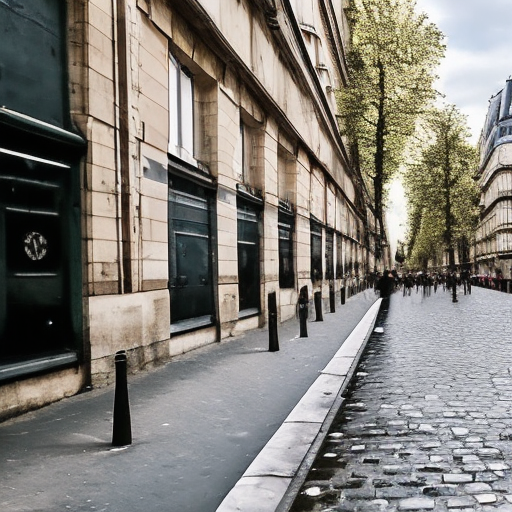

In [23]:
depth = depth_model.predict(img)

In [ ]:
print(depth.cpu()*100)

tensor([[260.0000, 260.0000, 260.0000,  ..., 260.7500, 261.0000, 261.0000],
        [260.2500, 260.2500, 260.2500,  ..., 261.0000, 261.0000, 261.0000],
        [260.0000, 260.2500, 260.2500,  ..., 261.0000, 261.0000, 261.0000],
        ...,
        [178.8750, 178.8750, 178.7500,  ..., 162.1250, 162.2500, 162.2500],
        [178.7500, 178.8750, 178.7500,  ..., 161.8750, 162.1250, 162.3750],
        [178.8750, 178.8750, 178.7500,  ..., 161.3750, 161.8750, 162.6250]],
       dtype=torch.float16)


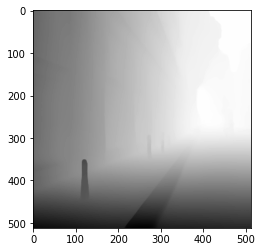

In [24]:
plt.imshow((depth*70).cpu().to(torch.uint8), cmap="gray")

  0%|          | 0/50 [00:00<?, ?it/s]

prev


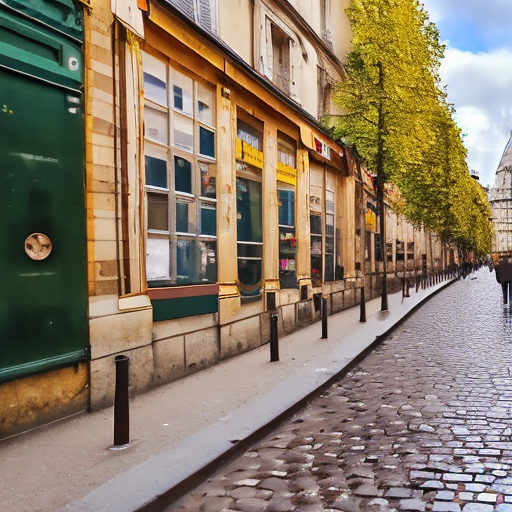

result


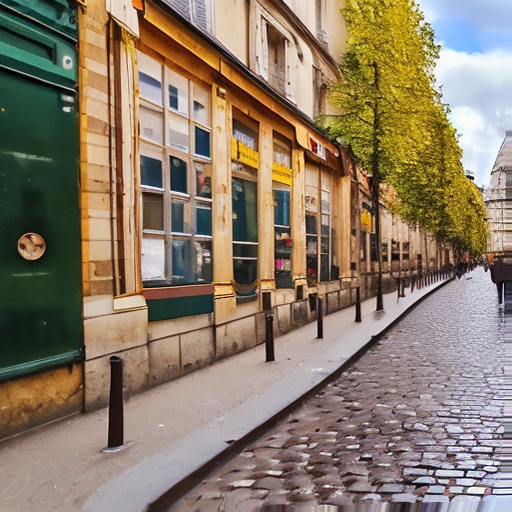

In [37]:
device = torch.device("cuda")

def controller(input_key):
    move_amount = 0.1
    rotate_amount = np.deg2rad(1)

    translate_xyz = [0, 0, 0]
    rotate_xyz = [0, 0, 0]
    if input_key == "w":    
        # move forward
        translate_xyz = [0, 0, -move_amount]
        rotate_xyz = [0, 0, 0]
    elif input_key == "a":
        # move left
        translate_xyz = [move_amount, 0, 0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "d":
        # move right
        translate_xyz = [-move_amount, 0, 0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "s":
        # move backward
        translate_xyz = [0, 0, -move_amount]
        rotate_xyz = [0, 0, 0]
    elif input_key == "t":
        # move up
        translate_xyz = [0, move_amount,0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "g":
        # move down
        translate_xyz = [0, -move_amount,0]
        rotate_xyz = [0, 0, 0]
    elif input_key == "q":
        # rotate left
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, -rotate_amount, 0]
    elif input_key == "e":
        # rotate right
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, rotate_amount, 0]
    elif input_key == "r":
        # look up
        translate_xyz = [0, 0, 0]
        rotate_xyz = [rotate_amount, 0, 0]
    elif input_key == "f":
        # look down
        translate_xyz = [0, 0, 0]
        rotate_xyz = [rotate_amount, 0, 0]
    elif input_key == "z":
        # rotate clockwise
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, 0, -rotate_amount]
    elif input_key == "x":
        # rotate countercolockwise
        translate_xyz = [0, 0, 0]
        rotate_xyz = [0, 0, rotate_amount]

    return translate_xyz, rotate_xyz

def transform_prev_img(prev_img: PIL.Image, depth: torch.Tensor,translate_xyz, rotate_xyz, device) -> PIL.Image:
    # tx-> move camera left
    # ty-> move camera up
    # tz -> move camera backward :why?
    # rx -> look up
    # ry -> look right
    # rz -> counterclockwise

    near=200,
    far=10_000,
    fov_deg=90,
    padding_mode="border"
    sampling_mode="bicubic"

    frame_idx = 0
    prev_img_cv2 = pil2cv(prev_img)
    depth_tensor = depth

    rot_mat = p3d.euler_angles_to_matrix(
        torch.tensor(rotate_xyz, device=device), "XYZ"
    ).unsqueeze(0)

    # transform_image_3d
    torch.cuda.empty_cache()

    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion
    w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]
    aspect_ratio = float(w) / float(h)
    persp_cam_old = p3d.FoVPerspectiveCameras(
        near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device
    )
    persp_cam_new = p3d.FoVPerspectiveCameras(
        near,
        far,
        aspect_ratio,
        fov=fov_deg,
        degrees=True,
        R=rot_mat,
        T=torch.tensor([translate_xyz]),
        device=device,
    )
    # range of [-1,1] is important to torch grid_sample's padding handling
    y, x = torch.meshgrid(
        torch.linspace(-1.0, 1.0, h, dtype=torch.float32, device=device),
        torch.linspace(-1.0, 1.0, w, dtype=torch.float32, device=device),
    )
    if depth_tensor is None:
        z = torch.ones_like(x)
    else:
        z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(
        xyz_old_world
    )[:, 0:2]
    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor(
        [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], device=device
    ).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(
        identity_2d_batch, [1, 1, h, w], align_corners=False
    )
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h, w, 2)).unsqueeze(0)
    image_tensor = rearrange(
        torch.from_numpy(prev_img_cv2.astype(np.float32)), "h w c -> c h w"
    ).to(device)
    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1 / 512 - 0.0001).unsqueeze(0),
        offset_coords_2d,
        mode=sampling_mode,
        padding_mode=padding_mode,
        align_corners=False,
    )
    # convert back to cv2 style numpy array
    result_cv2 = (
        rearrange(new_image.squeeze().clamp(0, 255), "c h w -> h w c")
        .cpu()
        .numpy()
        .astype(prev_img_cv2.dtype)
    )
    result = PIL.Image.fromarray(cv2.cvtColor(result_cv2, cv2.COLOR_BGR2RGB))
    return result
torch.manual_seed(0) 
img = pipe.text2img(
    prompt= "Photographs taken while walking through the streets of Paris, POV, trabel vlog, 4k, high quality",
    negative_prompt = "low quality, low resolution, blurry, black and white",
    num_inference_steps=50,
).images[0]
img

t, r = controller("e")
result = transform_prev_img(img, depth, t, r, device)
print("prev")
display.display(img)
print("result")
display.display(result)

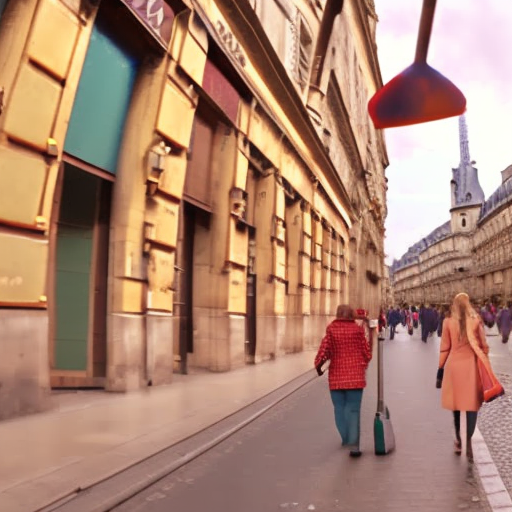

KeyboardInterrupt: ignored

In [38]:
prev_img = img
folder_path = "/content/drive/MyDrive/Project/deforumed_walk/rotate_tower"
prev_img.save(f"{folder_path}/{0}.png")

i = 0
while True:
    input_keys = input(f"{i}: keybord inputs = ")
    for input_key in input_keys:
        print(f"{i}: input_key = {input_key}")
        t,r = controller(input_key)
    
        prev_depth = depth_model.predict(prev_img)
        transformed_prev_img = transform_prev_img(prev_img, prev_depth, t, r, device)

        next_img = pipe.img2img(
            image=transformed_prev_img,
            prompt= "Photographs taken while walking through the streets of Paris, POV, trabel vlog, 4k, high quality",
            negative_prompt = "low quality, low resolution, blurry, black and white",
            strength = 0.75,
            num_inference_steps=50
        ).images[0]
    
        next_img.save(f"{folder_path}/{i}.png")
        display.clear_output(wait=True)
        display.display(next_img)

        prev_img = next_img
        i += 1

In [ ]:
!echo $folder_path/hoge

/content/drive/MyDrive/Project/deforumed_walk/rotate_tower/hoge


In [ ]:
import glob 
paths = glob.glob(f"{folder_path}/*.png")

CLIP_FPS = 2
filepath = "/content/drive/MyDrive/Project/deforumed_walk/out.mp4"
codec = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(filepath, codec, CLIP_FPS, (512,512))

for img_file in paths:
    img = cv2.imread(img_file)
    video.write(img)

video.release()